In [2]:
import json
import matplotlib
from matplotlib import pyplot as plt
matplotlib.rcParams.update({'figure.figsize': (9, 6), 'font.size': 14})
import numpy as np
import pandas as pd

### Old 5-fold results for both models

Here are results of multilabel model on 5-fold cross-validation.

In [4]:
df_beboc_folds = pd.DataFrame([])
df_beboc_folds['label'] = ['ORG', 'PER', 'LOC', 'MISC']
df_beboc_folds.set_index('label', drop=True, inplace=True)
for fold in range(5):
    with open(f'New_results/beboc_5folds/BEboC-5fold_tag_results_fold{fold}.json', 'r') as f:
        fold_results = json.load(f)
    df_beboc_folds[fold] = [fold_results[tag]['f1'] for tag in df_beboc_folds.index]
df_beboc_folds['mean'] = df_beboc_folds.mean(axis=1)
df_beboc_folds['std'] = df_beboc_folds.std(axis=1)
df_beboc_folds

,0,1,2,3,4,mean,std
label,,,,,,,
ORG,0.410359,0.411465,0.405611,0.426067,0.432537,0.417208,0.010275
PER,0.397562,0.400448,0.397485,0.409050,0.407216,0.402352,0.004874
LOC,0.436239,0.435460,0.448724,0.410581,0.416940,0.429589,0.013901
MISC,0.204791,0.186375,0.196737,0.184274,0.200563,0.194548,0.007978


In [6]:
df_bebic_folds = pd.DataFrame([])
# this model was '5-folded' on three labels data
df_bebic_folds['label'] = ['ORG', 'PER', 'LOC']
df_bebic_folds.set_index('label', drop=True, inplace=True)
for fold in range(5):
    with open(f'New_results/bebic_5folds/Bebic-5fold_head_results_fold{fold}.json', 'r') as f:
        fold_results = json.load(f)
        df_bebic_folds[fold] = [fold_results[tag]['f1'][-1] for tag in df_bebic_folds.index]
df_bebic_folds['mean'] = df_bebic_folds.mean(axis=1)
df_bebic_folds['std'] = df_bebic_folds.std(axis=1)
df_bebic_folds

,0,1,2,3,4,mean,std
label,,,,,,,
ORG,0.594738,0.651020,0.443727,0.683507,0.658451,0.606289,0.086307
PER,0.879235,0.331623,0.379631,0.315470,0.768274,0.534847,0.239420
LOC,0.891562,0.827101,0.880086,0.775045,0.861396,0.847038,0.042098


### 0 epochs of freezed shared layers

In [7]:
PATH_TO_BEBOC_RESULTS = 'New_results/beboc_misc_finetune/results_seed'
PATH_TO_BEBIC_RESULTS = 'New_results/Bebic_4th_head/results_dict_freezed'

In [8]:
# for multilabel model
def create_df_from_beboc_results(path_to_results, label):
    df = pd.DataFrame([])
    f1s = {}
    for seed in [1, 12, 123, 1234, 12345]:
        with open(path_to_results+str(seed)+'.json', 'r') as f:
            seed_results = json.load(f)
        samples = seed_results.keys()
        seed_f1s = [seed_results[s]['tags_results'][label]['f1'] for s in samples]
        if 'samples' not in df.columns:
            df['samples'] = samples
            df.set_index('samples', drop=True, inplace=True)
        df[seed] = seed_f1s
    df['mean'] = df.mean(axis=1)
    df['std'] = df.std(axis=1)
    return df

In [11]:
# for multihead model
def create_df_from_bebic_results(path_to_results, freezed_epochs, label):
    with open(path_to_results + str(freezed_epochs)+ '.json', 'r') as f:
        results_dict = json.load(f)
    df = pd.DataFrame([])
    for seed in results_dict.keys():
        samples = list(results_dict[seed].keys())
        f1s = [results_dict[seed][s]["head_results_all"][label]["f1"] for s in samples]
        df[seed] = f1s
    df['samples'] = samples
    df.set_index('samples', drop=True, inplace=True)
    df['mean'] = df.mean(axis=1)
    df['std'] = df.std(axis=1)
    return df

__New entity: MISC__

In [40]:
df_bebic = create_df_from_bebic_results(PATH_TO_BEBIC_RESULTS, 0, 'MISC')

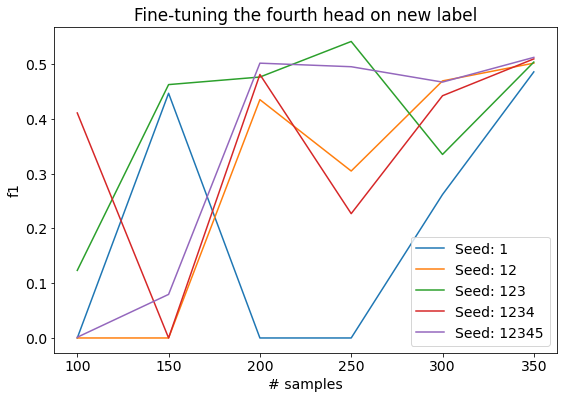

In [15]:
for seed in [1, 12, 123, 1234, 12345]:
    plt.plot(df_bebic.index, df_bebic[str(seed)], label=f'Seed: {seed}')
plt.ylabel("f1")
plt.xlabel("# samples")
plt.title("Fine-tuning the fourth head on new label")
_ = plt.legend()

In [41]:
df_beboc = create_df_from_beboc_results(PATH_TO_BEBOC_RESULTS, 'MISC')

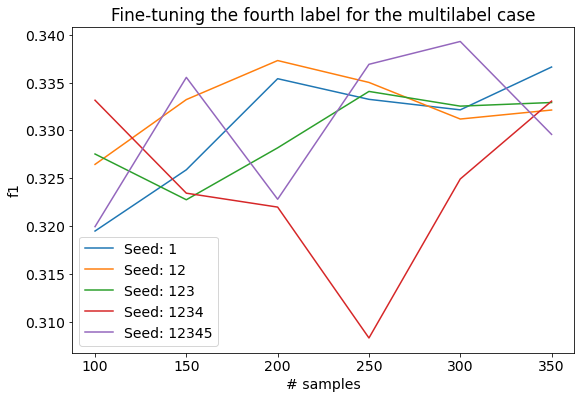

In [17]:
for seed in [1, 12, 123, 1234, 12345]:
    plt.plot(df_beboc.index, df_beboc[seed], label=f'Seed: {seed}')
plt.ylabel("f1")
plt.xlabel("# samples")
plt.title("Fine-tuning the fourth label for the multilabel case")
_ = plt.legend()

Comparing their means and old multilabel results

In [32]:
def compare_results(df_beboc, df_bebic, df_beboc_folds, df_bebic_folds, entity):
    multilabel_folds_mean = df_beboc_folds.loc[entity]['mean']
    multilabel_folds_std = df_beboc_folds.loc[entity]['std']

    plt.errorbar(df_bebic.index, df_bebic['mean'], df_bebic['std'], label='Multihead fine-tuning')
    plt.errorbar(df_beboc.index, df_beboc['mean'], df_beboc['std'], label='Multilabel fine-tunening')
    plt.hlines(multilabel_folds_mean, 0,5, label='Multilabel old result', color='g')
    plt.hlines(multilabel_folds_mean+multilabel_folds_std, 0,5, linestyles='dotted', color='g')
    plt.hlines(multilabel_folds_mean-multilabel_folds_std, 0,5, linestyles='dotted', color='g')
    if df_bebic_folds is not None:
        multihead_folds_mean = df_bebic_folds.loc[entity]['mean']
        multihead_folds_std = df_bebic_folds.loc[entity]['std']
        
        plt.hlines(multihead_folds_mean, 0,5, label='Multihead old result', color='m')
        plt.hlines(multihead_folds_mean+multihead_folds_std, 0,5, linestyles='dotted', color='m')
        plt.hlines(multihead_folds_mean-multihead_folds_std, 0,5, linestyles='dotted', color='m')
    plt.ylabel("f1")
    plt.xlabel("# samples")
    _ = plt.legend()

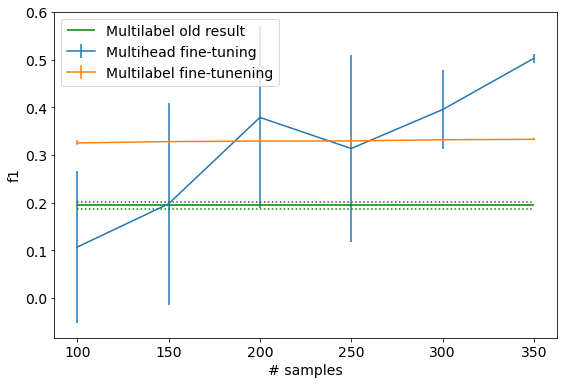

In [42]:
compare_results(df_beboc, df_bebic, df_beboc_folds, None, 'MISC')

__Old entites__

ORG

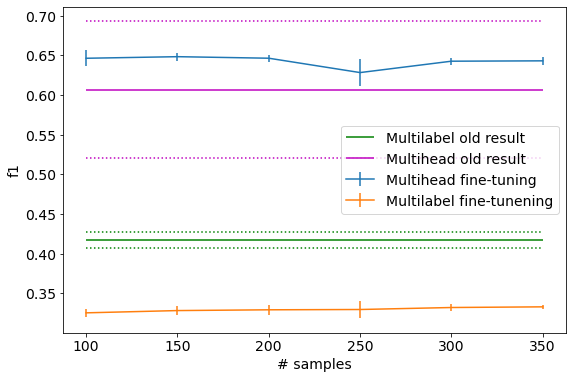

In [37]:
df_bebic = create_df_from_bebic_results(PATH_TO_BEBIC_RESULTS, 0, 'ORG')
df_beboc = create_df_from_beboc_results(PATH_TO_BEBOC_RESULTS, 'ORG')

compare_results(df_beboc, df_bebic, df_beboc_folds, df_bebic_folds, 'ORG')

LOC

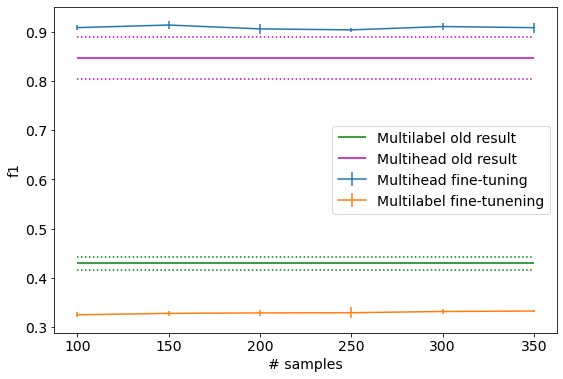

In [38]:
df_bebic = create_df_from_bebic_results(PATH_TO_BEBIC_RESULTS, 0, 'LOC')
df_beboc = create_df_from_beboc_results(PATH_TO_BEBOC_RESULTS, 'LOC')

compare_results(df_beboc, df_bebic, df_beboc_folds, df_bebic_folds, 'LOC')

PER

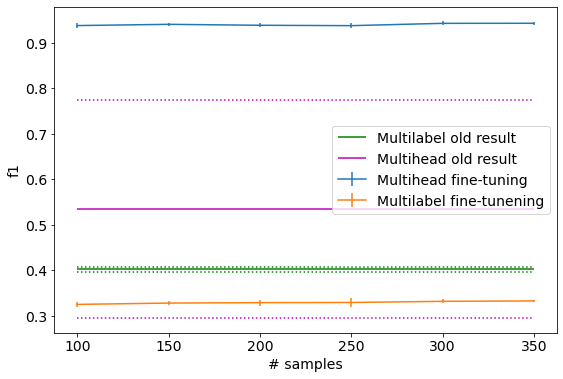

In [39]:
df_bebic = create_df_from_bebic_results(PATH_TO_BEBIC_RESULTS, 0, 'PER')
df_beboc = create_df_from_beboc_results(PATH_TO_BEBOC_RESULTS, 'PER')

compare_results(df_beboc, df_bebic, df_beboc_folds, df_bebic_folds, 'PER')

__Conclusion__: after training on 200+ new samples we have f1 on new label comparable with multilabel model (or even better). After training on 300+ new samples, multihead fine-tuning gives the best results. F1 scores on old labels are comparable with those that we head before fine-tuning.

### 1 epochs of freezed shared layers

New entity: MISC

In [43]:
df_bebic = create_df_from_bebic_results(PATH_TO_BEBIC_RESULTS, 1, 'MISC')

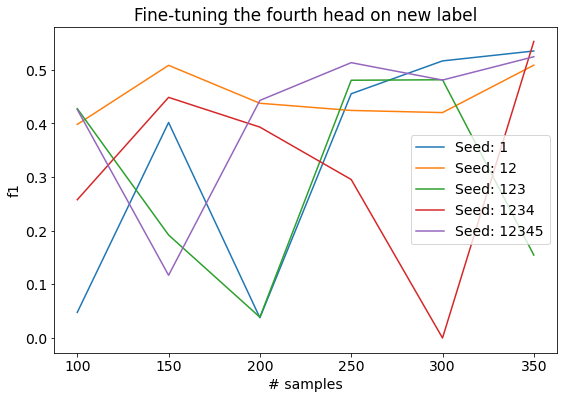

In [44]:
for seed in [1, 12, 123, 1234, 12345]:
    plt.plot(df_bebic.index, df_bebic[str(seed)], label=f'Seed: {seed}')
plt.ylabel("f1")
plt.xlabel("# samples")
plt.title("Fine-tuning the fourth head on new label")
_ = plt.legend()

We still compare it with simple multilabel model fine-tuning

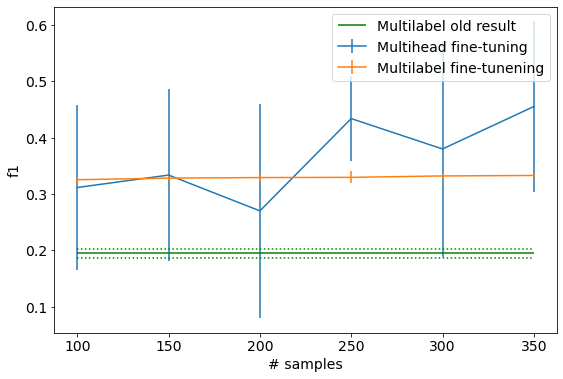

In [45]:
compare_results(df_beboc, df_bebic, df_beboc_folds, None, 'MISC')

After training on 250+ samples we see good enough results excluding one 'bad' case when we had 300 samples.

__Old entites__

ORG

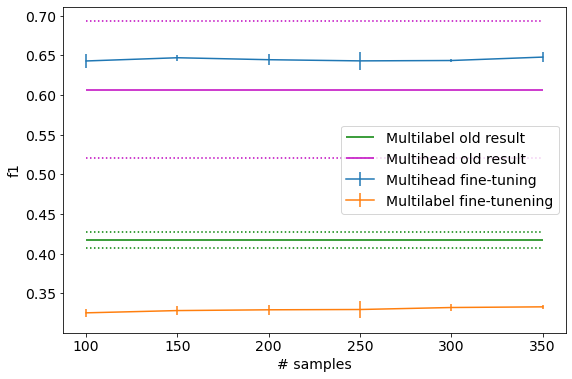

In [46]:
df_bebic = create_df_from_bebic_results(PATH_TO_BEBIC_RESULTS, 1, 'ORG')
df_beboc = create_df_from_beboc_results(PATH_TO_BEBOC_RESULTS, 'ORG')

compare_results(df_beboc, df_bebic, df_beboc_folds, df_bebic_folds, 'ORG')

LOC

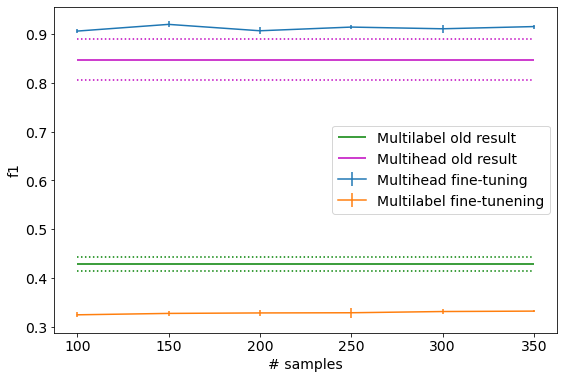

In [47]:
df_bebic = create_df_from_bebic_results(PATH_TO_BEBIC_RESULTS, 1, 'LOC')
df_beboc = create_df_from_beboc_results(PATH_TO_BEBOC_RESULTS, 'LOC')

compare_results(df_beboc, df_bebic, df_beboc_folds, df_bebic_folds, 'LOC')

PER

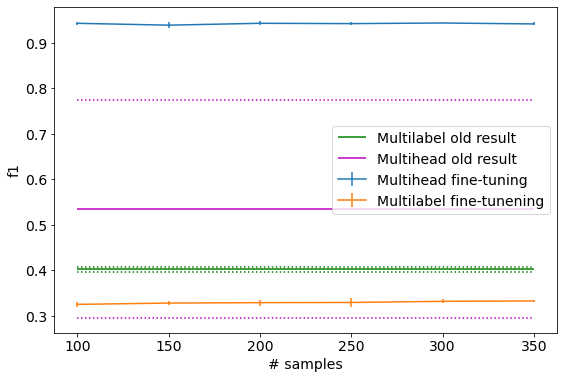

In [48]:
df_bebic = create_df_from_bebic_results(PATH_TO_BEBIC_RESULTS, 1, 'PER')
df_beboc = create_df_from_beboc_results(PATH_TO_BEBOC_RESULTS, 'PER')

compare_results(df_beboc, df_bebic, df_beboc_folds, df_bebic_folds, 'PER')

__Conclusion__: on new label we have not very but good results. F1 scores on old labels are still very good. As for me, it's possible that freezing the model's body on the first epoch doesn't significantly changes the final model performance because I used a linear scheduler that at early training steps makes learning rate to be very small.

### 2 epochs of freezed shared layers

New entity: MISC

In [49]:
df_bebic = create_df_from_bebic_results(PATH_TO_BEBIC_RESULTS, 2, 'MISC')

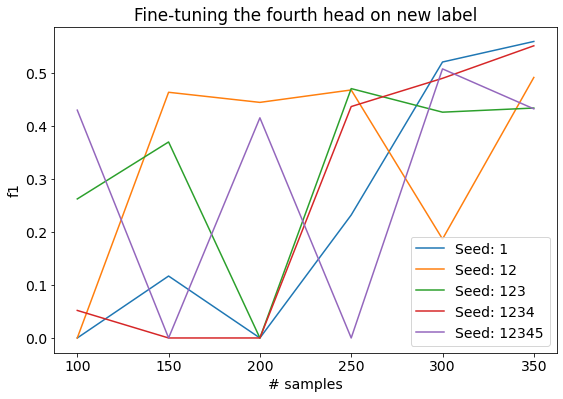

In [50]:
for seed in [1, 12, 123, 1234, 12345]:
    plt.plot(df_bebic.index, df_bebic[str(seed)], label=f'Seed: {seed}')
plt.ylabel("f1")
plt.xlabel("# samples")
plt.title("Fine-tuning the fourth head on new label")
_ = plt.legend()

We still compare it with simple multilabel model fine-tuning

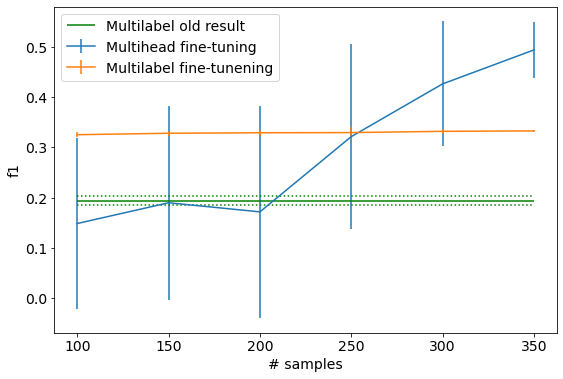

In [51]:
compare_results(df_beboc, df_bebic, df_beboc_folds, None, 'MISC')

Results on the new entity are good and similar to the first experiment (with 0 freezed epochs).

__Old entites__

ORG

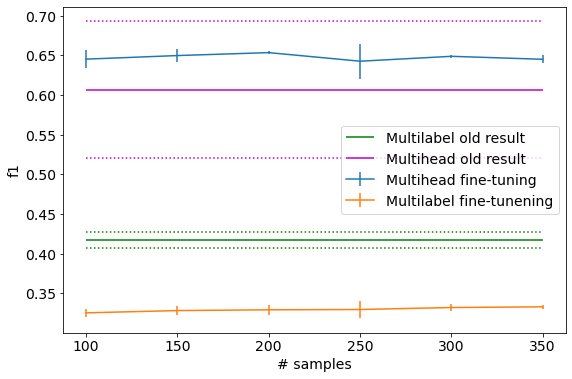

In [54]:
df_bebic = create_df_from_bebic_results(PATH_TO_BEBIC_RESULTS, 2, 'ORG')
df_beboc = create_df_from_beboc_results(PATH_TO_BEBOC_RESULTS, 'ORG')

compare_results(df_beboc, df_bebic, df_beboc_folds, df_bebic_folds, 'ORG')

LOC

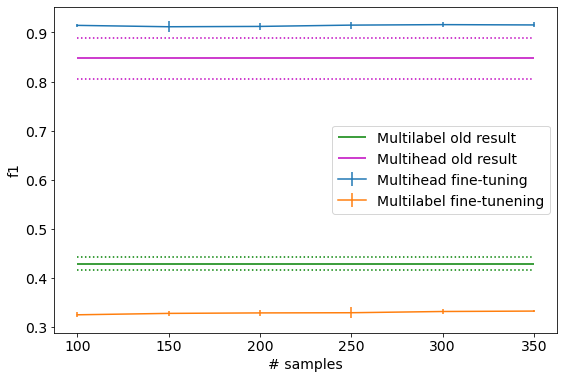

In [55]:
df_bebic = create_df_from_bebic_results(PATH_TO_BEBIC_RESULTS, 2, 'LOC')
df_beboc = create_df_from_beboc_results(PATH_TO_BEBOC_RESULTS, 'LOC')

compare_results(df_beboc, df_bebic, df_beboc_folds, df_bebic_folds, 'LOC')

PER

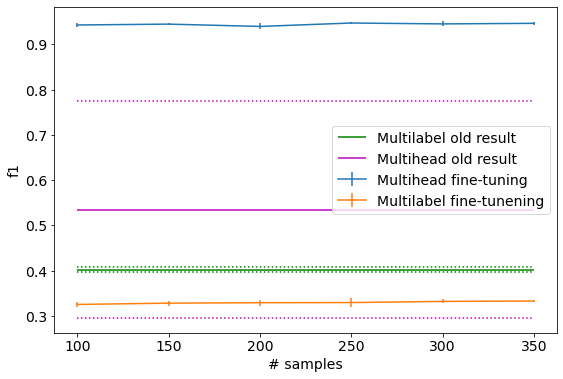

In [56]:
df_bebic = create_df_from_bebic_results(PATH_TO_BEBIC_RESULTS, 2, 'PER')
df_beboc = create_df_from_beboc_results(PATH_TO_BEBOC_RESULTS, 'PER')

compare_results(df_beboc, df_bebic, df_beboc_folds, df_bebic_folds, 'PER')

__Conclusion__: on new label we have good results. F1 scores on old labels are still very good.